# Initialization

In [1]:
import os
import grasp
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
from matplotlib import pyplot as plt
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')
tn1 = '20250401_164228'
tn2 = '20250401_164231'

pcs = grasp.load_data(tn1)
acs = grasp.load_data(tn2)


GAIA - GLOBULAR CLUSTERS ANALYSIS SOFTWARE
            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
         ::::::::::;;;::...

             INITIALIZED


Initialized with Gaia table: 'gaiadr3.gaia_source'


# Data visualization

<QTable length=1014>
         name          dtype     class     n_bad
--------------------- ------- ------------ -----
            SOURCE_ID   int64       Column     0
                   ra float64       Column     0
             ra_error float64       Column     0
                  dec float64       Column     0
            dec_error float64       Column     0
             parallax float64       Column     0
       parallax_error float64       Column     0
                 pmra float64       Column     0
           pmra_error float64       Column     0
                pmdec float64       Column     0
          pmdec_error float64       Column     0
      radial_velocity float64 MaskedColumn   923
radial_velocity_error float64 MaskedColumn   923
                bp_rp float64 MaskedColumn    31
      phot_g_mean_mag float64 MaskedColumn     1
     phot_bp_mean_mag float64 MaskedColumn    31
     phot_rp_mean_mag float64 MaskedColumn    30
         teff_gspphot float64 MaskedColumn   286

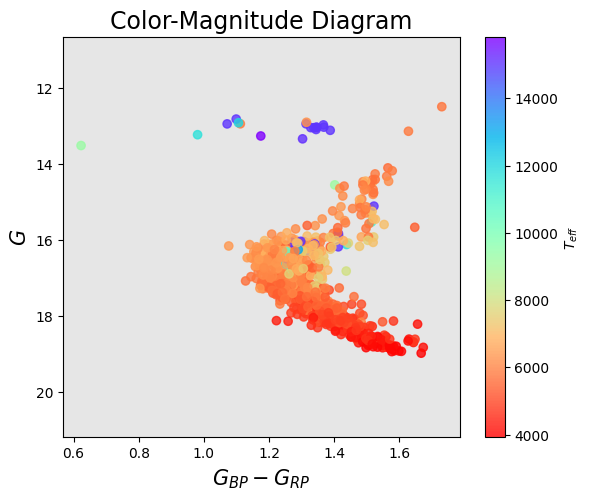

In [2]:
aps = acs.join(pcs)
aps.info()
grasp.plots.colorMagnitude(aps)

In [3]:
aps._merge_info.head()

,SOURCE_ID,_merge
0,6045225224274703488,both
1,6045285869214078464,both
2,6045359678233524224,both
3,6045384206788014080,right_only
4,6045385791639303296,both


# Angular Separation Analysis

The `Great Circle` formula versus the `Vincenty Formula` for the computation of distances on a sphere

## $\theta_V$   vs   $\theta_{GC}$

In [4]:
f = grasp.load_base_formulary()
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.value, 'delta_{0}':aps.gc.dec.value})

from sympy import atan2
atan_arg_1 = 'sqrt((cos(delta_1*sin((alpha_0 - alpha_1)/2)))**2 + (cos(delta_0)*sin(delta_1) - sin(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2 ))**2)'
atan_arg_2 = '(sin(delta_0)*sin(delta_1) + cos(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2))'
atan = atan2(atan_arg_1, atan_arg_2)
f.add_formula('Vincenty angsep', atan)
f.substitute('Vincenty angsep', {'alpha_0': aps.gc.ra.value, 'delta_0':aps.gc.dec.value})


f.angular_separation

Eq(theta, 2*asin(sqrt(0.177000071097462*sin(alpha_{1}/2 - 122.9479)**2*cos(delta_{1}) + sin(delta_{1}/2 + 13.2628)**2)))

In [5]:
f['Vincenty angsep']

Eq(f_0, atan2(sqrt(0.968670974831493*(0.179839587367255*sin(delta_1) + cos(delta_1)*cos(alpha_1/2 - 122.9479))**2 + cos(delta_1*sin(alpha_1/2 - 122.9479))**2), -0.984210838607*sin(delta_1) + 0.177000071097462*cos(delta_1)*cos(alpha_1/2 - 122.9479)))

In [6]:
f.var_order('Angular Separation')
print('')
f.var_order('Vincenty angsep')


`Angular separation' variables must be passed in the following order:
Data         : [alpha_{1}, delta_{1}]
Errors       : [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations : [rho_alpha_{1}_delta_{1}]


`Vincenty angsep' variables must be passed in the following order:
Data         : [alpha_1, delta_1]
Errors       : [epsilon_alpha_1, epsilon_delta_1]
Correlations : [rho_alpha_1_delta_1]


Great Circle Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Computation using all 8 cores.

Vincenty Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_1, delta_1]
Computation using all 8 cores.


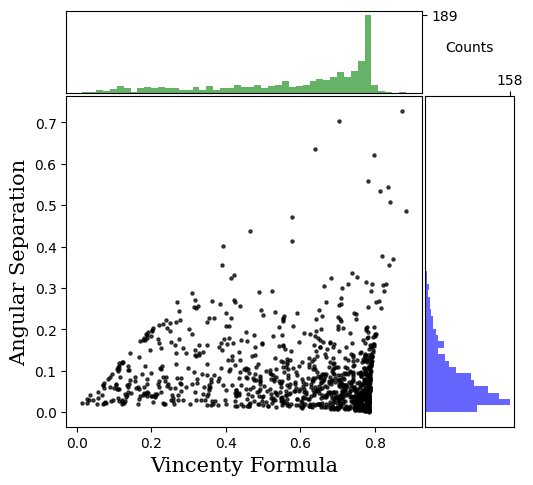

In [7]:
ra, dec = (aps.ra.value, aps.dec.value)
print("Great Circle Distance computation\n")
theta_1 = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, asarray=True)
print("\nVincenty Distance computation\n")
theta_2 = f.compute('Vincenty angsep', data={'alpha_1': ra, 'delta_1': dec}, asarray=True)

grasp.plots.doubleHistScatter(theta_2, theta_1, xlabel='Vincenty Formula', ylabel='Angular Separation')

Correctly imported `minpack.lm`.


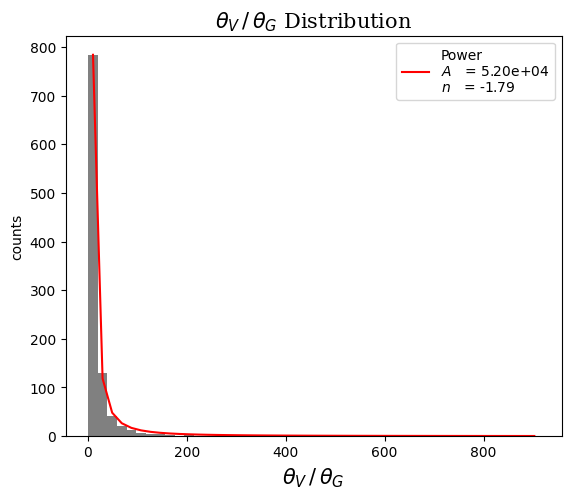

A = 51994.87  ;  lambda = -1.79


In [8]:
t_ratio = theta_2/theta_1
out = grasp.plots.histogram(t_ratio, kde=True, kde_kind='power', xlabel=r'$\theta_V\,/\,\theta_G$', out=True)
fit = out['kde']
print(f"A = {fit[0]:.2f}  ;  lambda = {fit[1]:.2f}")

Exponential fit: A = 0.42  ;  lambda = -1.11


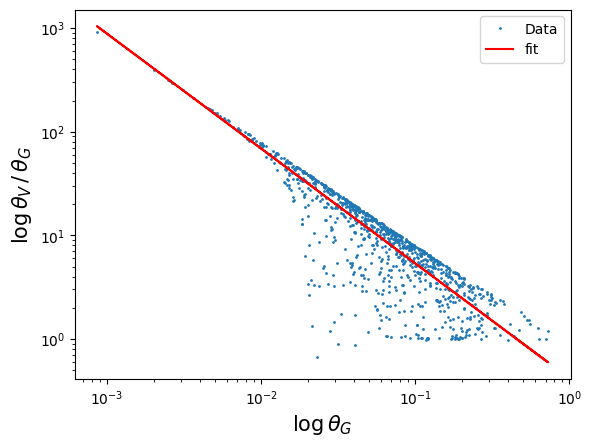

In [9]:
fit = grasp.stats.fit_data(theta_1[t_ratio<400], t_ratio[t_ratio<400], fit='power')

coeffs = fit['parameters']

exp = grasp.stats._get_function('power')
exp = exp(theta_1, *coeffs)
print(f"Exponential fit: A = {coeffs[0]:.2f}  ;  lambda = {coeffs[1]:.2f}")

plt.plot(theta_1, t_ratio, 'o', markersize=1, label='Data')
plt.plot(theta_1, exp, c='r', label='fit')
plt.xlabel(r'$\log{\theta_G}$', fontdict=grasp.plots.label_font)
plt.ylabel(r'$\log{\theta_V\,/\,\theta_G}$', fontdict=grasp.plots.label_font)
plt.yscale('log')
plt.xscale('log')
plt.legend()

## $r_{2D}(\theta_V)$ vs $r_{2D}(\theta_{GC})$

In [10]:
aps.gc.dist = 1851 # Baumgardt, Vasiliev: 2021 # pc
f.substitute('radial_distance_2d', {'r_{c}': aps.gc.dist})
f.radial_distance_2d

Eq(r_{2}, 1851*tan(theta))

In [11]:
f.var_order('radial_distance_2d')


`Radial distance 2d' variables must be passed in the following order:
Data         : [theta]
Errors       : [epsilon_theta]
Correlations : None


In [12]:
print(r'Computation using $\theta_{GC}$')
r2d_1 = f.compute('radial_distance_2d', data={'theta': theta_1}, asarray=True)
print('')
print(r'Computation using $\theta_{V}$')
r2d_2 = f.compute('radial_distance_2d', data={'theta': theta_2}, asarray=True)

r_ratio = r2d_2/r2d_1

Computation using $\theta_{GC}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Computation using all 8 cores.

Computation using $\theta_{V}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Computation using all 8 cores.


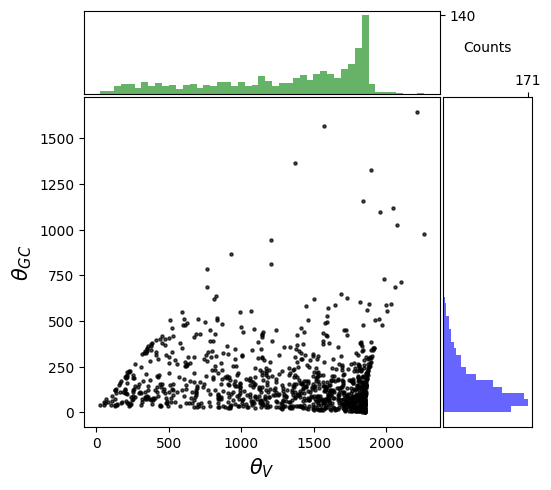

In [13]:
grasp.plots.doubleHistScatter(r2d_2, r2d_1, xlabel=r'$\theta_{V}$', ylabel=r'$\theta_{GC}$')

Correctly imported `minpack.lm`.


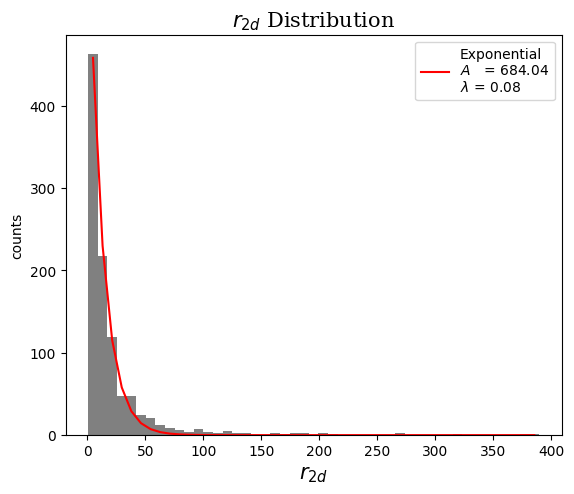

In [14]:
grasp.plots.histogram(r_ratio[r_ratio<400], kde=True, kde_kind='exponential', xlabel=r'$r_{2d}$')

Correctly imported `minpack.lm`.


findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


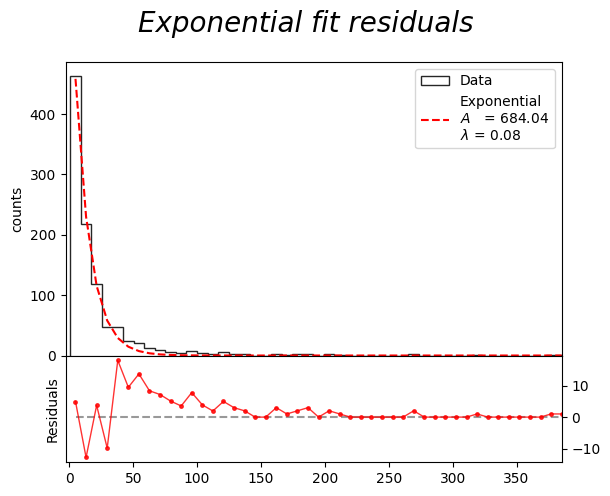

In [18]:
reg_e = grasp.stats.regression(r_ratio[r_ratio<400], 'exponential', False)
grasp.plots.regressionPlot(reg_e, title='Exponential fit residuals')

Correctly imported `minpack.lm`.


findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


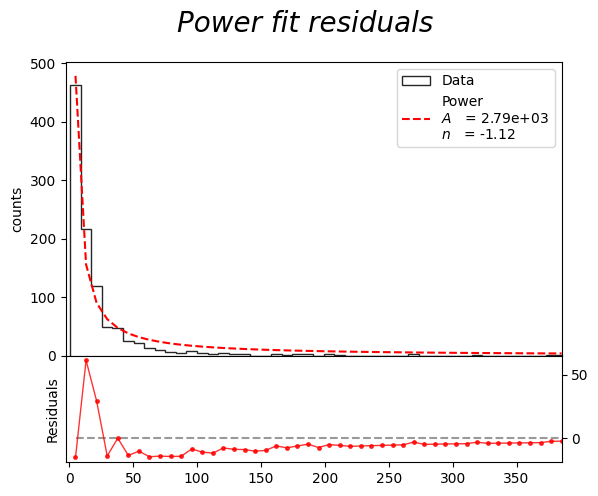

In [19]:
reg_p = grasp.stats.regression(r_ratio[r_ratio<400], 'power', False)
grasp.plots.regressionPlot(reg_p, title='Power fit residuals')

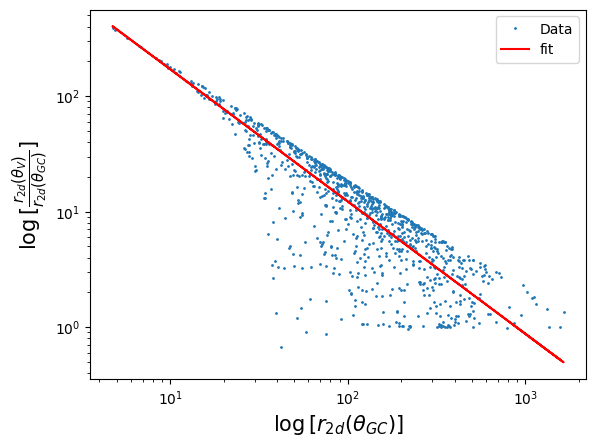

In [17]:
fit = grasp.stats.fit_data(r2d_1[r_ratio<400], r_ratio[r_ratio<400], fit='power')

plt.plot(r2d_1[r_ratio<400], r_ratio[r_ratio<400], 'o', markersize=1, label='Data')
plt.plot(r2d_1[r_ratio<400], fit['y-fit'], c='r', label='fit')
plt.xlabel(r'$\log{[r_{2d}(\theta_{GC})]}$', fontdict=grasp.plots.label_font)
plt.ylabel(r'$\log{[\frac{r_{2d}(\theta_{V})}{r_{2d}(\theta_{GC})}]}$', fontdict=grasp.plots.label_font)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [26]:
reg_p.x

array([  4.80849157,  13.08038787,  21.35228417,  29.62418047,
        37.89607677,  46.16797307,  54.43986937,  62.71176568,
        70.98366198,  79.25555828,  87.52745458,  95.79935088,
       104.07124718, 112.34314348, 120.61503979, 128.88693609,
       137.15883239, 145.43072869, 153.70262499, 161.97452129,
       170.24641759, 178.51831389, 186.7902102 , 195.0621065 ,
       203.3340028 , 211.6058991 , 219.8777954 , 228.1496917 ,
       236.421588  , 244.6934843 , 252.96538061, 261.23727691,
       269.50917321, 277.78106951, 286.05296581, 294.32486211,
       302.59675841, 310.86865472, 319.14055102, 327.41244732,
       335.68434362, 343.95623992, 352.22813622, 360.50003252,
       368.77192882, 377.04382513, 385.31572143])